In [6]:
using Images
using Statistics
using PythonPlot
using DSP
using StatsBase
using VectorizedStatistics
using ImageMorphology
mpl = PythonPlot.pyimport("matplotlib")
mpl.rcParams["svg.fonttype"] = "none"

"none"

In [2]:
function mask_site(file, threshold; n_sites=1)
    img = load(file)
    im_array = Float64.(img) * 65535 # concert to 16bit
    # Don't do frame averaging. Was found not neccessary for images used. 
    # Use stack standard dev projection to find polarity patch(es)
    img_std = std(im_array, dims=(3))[:,:,1]
    max_bin = 0
    bin = img_std .> maximum(img_std)*threshold
    bin = dilate(bin, r=1)
    bin_lab = label_components(bin)
    masks = zeros(size(im_array)[1], size(im_array)[2], size(im_array)[3], n_sites)
    for i in range(1,n_sites)
        bin = bin .- max_bin         
        max_loc = findmax(bin.*img_std)[2]          # mask the image. find the max. get the coords.
        max_lab = bin_lab[max_loc]                  # get label in labeled mask from coords
        max_bin = bin_lab .== max_lab               # Make binary mask only around correct component
        im_masked = im_array .* max_bin 
        masks[:,:,:,i] = im_masked
    end
    return masks
end

mask_site (generic function with 1 method)

In [17]:
# Modified for mutli-signal to return times instead of time-crops
function crop_times(signal, frames, thresh)
    signal=signal.-minimum(signal)
    start = Integer(findall(signal .> ((maximum(signal))*thresh))[1])
    if start + frames < length(signal)
        times = start:start+Integer(frames)
        return times
    else 
        last = length(signal)
        times = last-Integer(frames):last
        print(".")
        return times
    end
end

crop_times (generic function with 1 method)

In [4]:
file = "../data/double_probe/cell6-g.tif"
img = load(file)
g = Float64.(img) * 65535
file = "../data/double_probe/cell6-r.tif"
img = load(file)
r = Float64.(img) * 65535;

Loading: 100%|███████████████████████████████████████████| Time: 0:00:01


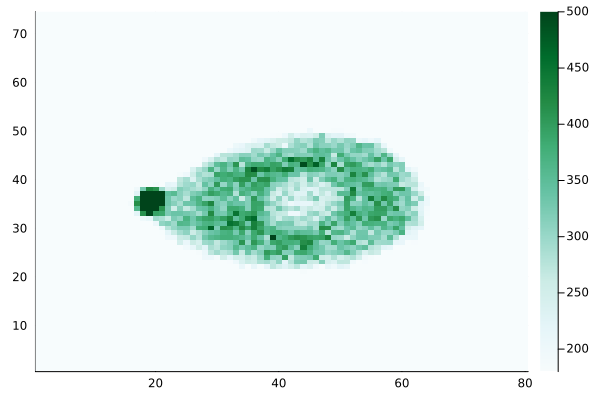

In [94]:
heatmap(g[:,:,end], cmap=:BuGn, clim=(180,500))

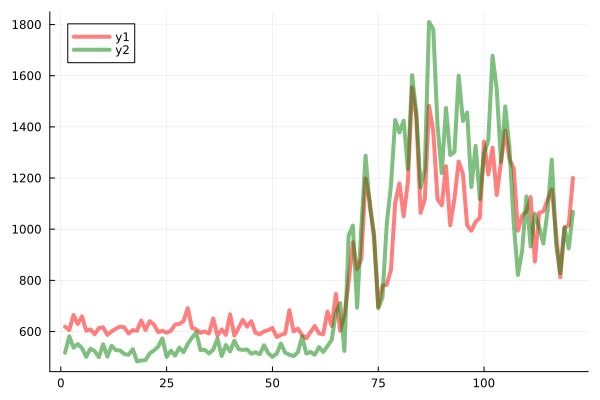

In [44]:
signal_r = maximum(r, dims=(1,2))[1,1,:]
signal_g = maximum(g, dims=(1,2))[1,1,:]
plot(signal_r * (mean(signal_g) / mean(signal_r)), color="red", linewidth=4, alpha=0.5)
plot!(signal_g, color="green", linewidth=4, alpha=0.5)

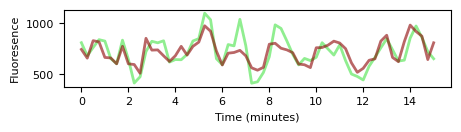

In [30]:
file_g = "../data/double_probe/cell5-g.tif"
file_r = "../data/double_probe/cell5-r.tif"

interval = 15
time_threshold=0.5
m1 = mask_site(file_g, 0.5, n_sites=1);
m2 = mask_site(file_r, 0.5, n_sites=1);
im_size = length(m1[:,1,1])*length(m1[1,:,1])
q1 = maximum(m1, dims=(1,2))[1,1,:]
q2 = maximum(m2, dims=(1,2))[1,1,:]
times_max1 = crop_times(q1, 15*(60/interval), time_threshold)
times_max2 = crop_times(q2, 15*(60/interval), time_threshold)
crop1 = q1[max(times_max1, times_max2)]
crop2 = q2[max(times_max1, times_max2)]
t = range(0,60/15*15)*(15/60) # Convert from 1 frame every 5 sec, to minutes


fig, ax = subplots(figsize=(5,1))
ax.plot(t, crop1, linewidth=2, color="lightgreen")
ax.plot(t, crop2*(mean(crop1)/ mean(crop2)), linewidth=2, color="darkred", alpha=0.6)
ax.set_ylabel("Fluoresence", fontsize=8)
ax.set_xlabel("Time (minutes)", fontsize=8)
ax.tick_params(labelsize=8)

savefig("../figures/trace_2probe_c5.svg")
display(gcf())


....

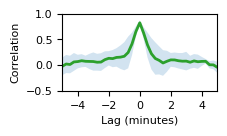

Python: None

In [62]:
all_cor = zeros(61, 6)
for n in 1:6
    file_g = "../data/double_probe/cell$n-g.tif"
    file_r = "../data/double_probe/cell$n-r.tif"
    cell = "cell$n"

    interval = 15
    time_threshold=0.5
    m1 = mask_site(file_g, 0.5, n_sites=1);
    m2 = mask_site(file_r, 0.5, n_sites=1);
    im_size = length(m1[:,1,1])*length(m1[1,:,1])
    q1 = vquantile(m1, (im_size-1)/im_size, dims=(1,2))[1,1,:]
    q2 = vquantile(m2, (im_size-1)/im_size, dims=(1,2))[1,1,:]
    times_max1 = crop_times(q1, 15*(60/interval), time_threshold)
    times_max2 = crop_times(q2, 15*(60/interval), time_threshold)
    crop1 = q1[max(times_max1, times_max2)]
    crop2 = q2[max(times_max1, times_max2)]
    t = range(0,60/15*15)*(15/60) # Convert from 1 frame every 15 sec, to minutes


    #fig, ax = subplots(figsize=(2.5,0.5))
    #ax.plot(t, crop1, linewidth=2, color="lightgreen")
    #ax.plot(t, crop2*(mean(crop1)/ mean(crop2)), linewidth=2, color="darkred", alpha=0.6)
    #ax.tick_params(left = false, right = false , labelleft = false, labelbottom = false, bottom = false) 

    #savefig("../figures/trace_2probe_$(cell).svg", transparent=true)

    xcor = crosscor(crop1, crop2, -30:30)
    all_cor[:,n] = xcor
end

t_cor = range(-30,30)*(15/60)
cor = mean(all_cor, dims=2)
stdev = std(all_cor, dims=2)

fig, ax = subplots(figsize=(2,1))
ax.plot(t_cor, cor, color="C02", linewidth=2, label="Cross corr.")
ax.fill_between(t_cor, (cor.+stdev)[:], (cor.-stdev)[:], alpha=0.2)
ax.set_ylabel("Correlation", fontsize=8)
ax.set_xlabel("Lag (minutes)", fontsize=8)
ax.tick_params(labelsize=8)
ax.set_xlim(-5,5)
ax.set_xticks(-4:2:4)
ax.set_yticks([-0.5,0.0,0.5,1.0])
#ax.legend(fontsize=8)

display(gcf())
savefig("../figures/ac_2probe_$(cell).svg", transparent=true)

In [44]:

fig, ax = subplots(figsize=(2.5,0.5))
ax.plot(crop2, linewidth=2, color="C0")
ax.plot(crop1, linewidth=2, color="C1")
ax.tick_params(left = false, right = false , labelleft = false, labelbottom = false, bottom = false) 
savefig("../figures/naked_2patch/$(cell).svg", transparent=true)

PythonCall.Core.PyException: Python: FileNotFoundError: [Errno 2] No such file or directory: '../figures/naked_2patch/cell1.svg'

In [ ]:
mask = mask_site("$dir$f")
max_patch = maximum(mask, dims=(1,2))[1,1,:]
crop_max = crop_time(max_patch, 15*(60/5), 0.5)
t = range(1,length(crop_max))*(5/60)

cell = replace(f,".tif" => "")

n+=1

plot(size=(400,100))
plot!(t, crop_max, linewidth=2, label=false, dpi=600, grid=false, xticks=false, yticks=false, framestyle = :box)
    savefig("../figures/naked_traces/$cell.png")